#### CSCE 670 :: Information Storage & Retrieval :: Texas A&M University :: Fall 2025


# Homework 4: Sequential RecSys + LLM Fun Times

### 100 points [7% of your final grade]

### Due Saturday, November 22 by 11:59pm CT

*Goals of this homework:* The objective of this homework is to get you familiar with the RecBole package, experiment with different sequential recommendation systems, and find recommendation cases that either pass or fail LLMs like ChatGPT or Gemini.

*Submission instructions (Canvas):* To submit your homework, rename this notebook as **your-uin_hw4.ipynb**. For example, my homework submission would be something like **735009638_hw4.ipynb**. Submit this notebook via Canvas (look for the homework 4 assignment there). Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit.

*Late submission policy:* For this homework, you may use as many late days as you like (up to the 5 total allotted to you).

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Canvas, search StackOverflow, even use ChatGPT. But if you do get help in this way, you must specify it in the code comments.

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Part 1. Building sequential recommenders using RecBole (50 points total)

In this first part, we're going to build **sequential** recommenders using the RecBole package. Specifically, we will explore [TransRec](https://recbole.io/docs/user_guide/model/sequential/transrec.html#running-with-recbole) and [FOSSIL](https://recbole.io/docs/user_guide/model/sequential/fossil.html#running-with-recbole), as mentioned in our classes. Additionally, we will compare their performance with other sequential recomenders.

We will use the `ml-100k` data from the RecBole package. MovieLens 100K movie ratings dataset is a benchmark dataset that contains 100,000 ratings from 1000 users on 1700 movies. You need to use the TransRec and FOSSIL implementations provided by RecBole, followed by an analysis of their performance.

In [2]:
!pip install recbole
!pip install ray
!pip install kmeans_pytorch
!pip install numpy==1.26.4


In [3]:
import shutil
shutil.rmtree('saved', ignore_errors=True)


In [4]:
import torch
_real_load = torch.load

def patched_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return _real_load(*args, **kwargs)

torch.load = patched_load


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from recbole.quick_start import run_recbole
import pandas as pd

In [ ]:

fossil_config = {
    # FOSSIL REQUIRED SETTINGS
    'loss_type': 'CE',                 # CE = no negative sampling
    'train_neg_sample_args': None,     # MUST be None (fixes your error)

    # FOSSIL HYPERPARAMETERS (defaults shown)
    'embedding_size': 64,
    'order_len': 3,
    'alpha': 0.6,
    'reg_weight': 0.0,

    # Training settings (you can add/remove)
    'epochs': 50,
    'learning_rate': 1e-3,
    'train_batch_size': 2048,

    # Evaluation settings
    'topk': 10,
    'metrics': ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision'],
    'valid_metric': 'NDCG@10',
    'eval_args': {
        'split': {'RS': [0.8, 0.1, 0.1]},
        'order': 'TO',
        'mode': 'full'
    },

    # Optional: speeds up FOSSIL a LOT
    'reproducibility': False,
}

# Run FOSSIL on MovieLens-100K
fossil_result = run_recbole(
    model='FOSSIL',
    dataset='ml-100k',
    config_dict=fossil_config
)

print(fossil_result)


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [ ]:
transrec_config = {
    # TRANSREC REQUIRED SETTINGS
    'loss_type': 'BPR',                      # TransRec MUST use pairwise BPR loss
    'train_neg_sample_args': {
        'distribution': 'uniform',
        'sample_num': 1
    },

    # TransRec hyperparameters (defaults shown)
    'embedding_size': 64,

    # Training settings
    'epochs': 50,
    'learning_rate': 1e-3,
    'train_batch_size': 2048,

    # Evaluation settings
    'topk': 10,
    'metrics': ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision'],
    'valid_metric': 'NDCG@10',
    'eval_args': {
        'split': {'RS': [0.8, 0.1, 0.1]},
        'order': 'TO',
        'mode': 'full'
    },

    # Optional
    'seed': 42,
}

# Run TransRec on MovieLens-100K
transrec_result = run_recbole(
    model='TransRec',
    dataset='ml-100k',
    config_dict=transrec_config
)

print(transrec_result)


In [18]:
print(fossil_result)
print(transrec_result)

{'best_valid_score': 0.0431, 'valid_score_bigger': True, 'best_valid_result': OrderedDict({'recall@10': 0.0936, 'mrr@10': 0.0281, 'ndcg@10': 0.0431, 'hit@10': 0.0936, 'precision@10': 0.0094}), 'test_result': OrderedDict({'recall@10': 0.0976, 'mrr@10': 0.029, 'ndcg@10': 0.0448, 'hit@10': 0.0976, 'precision@10': 0.0098})}
{'best_valid_score': 0.0332, 'valid_score_bigger': True, 'best_valid_result': OrderedDict({'recall@10': 0.0702, 'mrr@10': 0.0221, 'ndcg@10': 0.0332, 'hit@10': 0.0702, 'precision@10': 0.007}), 'test_result': OrderedDict({'recall@10': 0.0667, 'mrr@10': 0.0197, 'ndcg@10': 0.0305, 'hit@10': 0.0667, 'precision@10': 0.0067})}


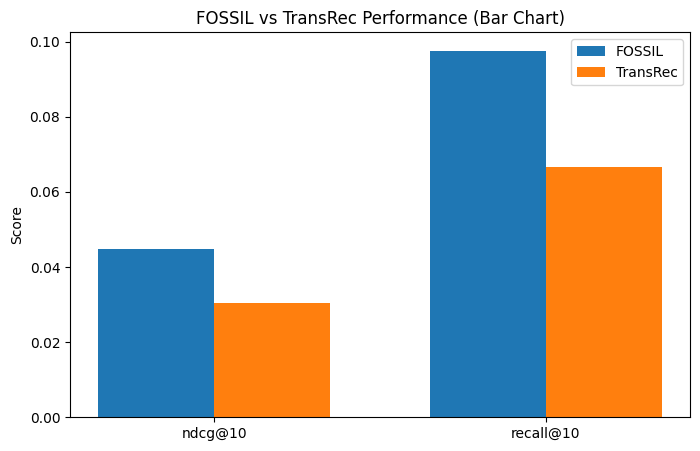

In [21]:

metrics = ['ndcg@10', 'recall@10']

fossil_vals = [fossil_result['test_result'][m] for m in metrics]
transrec_vals = [transrec_result['test_result'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, fossil_vals, width, label='FOSSIL')
plt.bar(x + width/2, transrec_vals, width, label='TransRec')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('FOSSIL vs TransRec Performance (Bar Chart)')
plt.legend()

plt.show()


# Tuning Hyper Parameters (10 points)
In this part, we will play with the parameters, like learning rate and embedding size, and then show your findings along with analysis.

In [ ]:
def extract_metrics(result):
    test = result["test_result"]
    return {
        "ndcg@10": test["ndcg@10"],
        "recall@10": test["recall@10"]
    }

In [ ]:
learning_rates = [1e-4, 1e-3]
embedding_sizes = [32, 64, 128]

In [ ]:


fossil_records = []

for lr in learning_rates:
    for emb in embedding_sizes:

        fossil_config = {
            'loss_type': 'CE',
            'train_neg_sample_args': None,
            'embedding_size': emb,
            'order_len': 3,
            'alpha': 0.6,
            'reg_weight': 0.0,

            'epochs': 50,
            'learning_rate': lr,
            'train_batch_size': 2048,

            'topk': 10,
            'metrics': ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision'],
            'valid_metric': 'NDCG@10',
            'eval_args': {
                'split': {'RS': [0.8, 0.1, 0.1]},
                'order': 'TO',
                'mode': 'full'
            },

            'reproducibility': False,
        }

        print(f"\n=== Running FOSSIL | lr={lr} | emb={emb} ===")
        fossil_result = run_recbole(model='FOSSIL',
                                    dataset='ml-100k',
                                    config_dict=fossil_config)

        metrics = extract_metrics(fossil_result)
        fossil_records.append({
            "model": "FOSSIL",
            "learning_rate": lr,
            "embedding_size": emb,
            **metrics
        })

fossil_df = pd.DataFrame(fossil_records)
print("\n\n===== FOSSIL Hyperparameter Tuning Results =====")
display(fossil_df)







=== Running FOSSIL | lr=0.0001 | emb=32 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running FOSSIL | lr=0.0001 | emb=64 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running FOSSIL | lr=0.0001 | emb=128 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running FOSSIL | lr=0.001 | emb=32 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running FOSSIL | lr=0.001 | emb=64 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running FOSSIL | lr=0.001 | emb=128 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c



===== FOSSIL Hyperparameter Tuning Results =====


,model,learning_rate,embedding_size,ndcg@10,recall@10
0,FOSSIL,0.0001,32,0.0159,0.0344
1,FOSSIL,0.0001,64,0.0172,0.0390
2,FOSSIL,0.0001,128,0.0216,0.0479
3,FOSSIL,0.0010,32,0.0470,0.1018
4,FOSSIL,0.0010,64,0.0448,0.0976
5,FOSSIL,0.0010,128,0.0387,0.0878



=== Running TransRec | lr=0.0001 | emb=32 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running TransRec | lr=0.0001 | emb=64 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running TransRec | lr=0.0001 | emb=128 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running TransRec | lr=0.001 | emb=32 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running TransRec | lr=0.001 | emb=64 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c


=== Running TransRec | lr=0.001 | emb=128 ===


/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:648: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  feat[field].fillna(value=0, inplace=True)
/usr/local/lib/python3.12/dist-packages/recbole/data/dataset/dataset.py:650: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [ ]:
# Tuning TransRec

transrec_records = []

for lr in learning_rates:
    for emb in embedding_sizes:

        transrec_config = {
            'loss_type': 'BPR',
            'train_neg_sample_args': {'distribution': 'uniform',
                                      'sample_num': 1},

            'embedding_size': emb,
            'epochs': 50,
            'learning_rate': lr,
            'train_batch_size': 2048,

            'topk': 10,
            'metrics': ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision'],
            'valid_metric': 'NDCG@10',
            'eval_args': {
                'split': {'RS': [0.8, 0.1, 0.1]},
                'order': 'TO',
                'mode': 'full'
            },

            'seed': 42,
        }

        print(f"\n=== Running TransRec | lr={lr} | emb={emb} ===")
        transrec_result = run_recbole(model='TransRec',
                                      dataset='ml-100k',
                                      config_dict=transrec_config)

        metrics = extract_metrics(transrec_result)
        transrec_records.append({
            "model": "TransRec",
            "learning_rate": lr,
            "embedding_size": emb,
            **metrics
        })

transrec_df = pd.DataFrame(transrec_records)
print("\n\n===== TransRec Hyperparameter Tuning Results =====")
display(transrec_df)

your analysis here

# Compare with other sequential recommender (20 points)
You should select at least one other sequential recommender from the RecBole package. Show its performance in comparison to the above two recsys and analyze why you think it performs better or worse. This may require you skimming the paper or diving into the model details.

In [ ]:
from recbole.quick_start import run_recbole

sasrec_config = {
    # SASRec is trained with BPR pairwise loss
    'loss_type': 'BPR',
    'train_neg_sample_args': {'distribution': 'uniform', 'sample_num': 1},

    # SASRec hyperparameters (default values)
    'embedding_size': 64,
    'hidden_size': 64,
    'num_layers': 2,
    'num_heads': 2,
    'dropout_prob': 0.2,
    'max_seq_length': 50,

    # Training
    'epochs': 20,
    'learning_rate': 1e-3,
    'train_batch_size': 2048,

    # Evaluation
    'topk': 10,
    'metrics': ['Recall', 'MRR', 'NDCG', 'Hit', 'Precision'],
    'valid_metric': 'NDCG@10',
    'eval_args': {
        'split': {'RS': [0.8, 0.1, 0.1]},
        'order': 'TO',
        'mode': 'full'
    },

    'seed': 42,
}

sasrec_result = run_recbole(
    model='SASRec',
    dataset='ml-100k',
    config_dict=sasrec_config
)

print("\n=== SASRec Result ===")
print(sasrec_result)


your analysis here

  # Part 2. ChatGPT (50 points total)

For this part, we will explore the recommendation performance of either [ChatGPT](https://chat.openai.com/) or [Gemini](https://gemini.google.com/):

* find two cases where ChatGPT (or Gemini) performs well,
* find two cases where ChatGPT (or Gemini) fails and analyze the reasons behind the failures.

You have great leeway in how you approach this problem. Is it a ratings prediction task? Or a ranking task? Or a pairwise comparison task? What kinds of items and what kinds of users? How should you prompt? These are all open questions.###

### Example 1: give 20(even 100) possible candidates with the real relevant one in the middle, yet GPT was able to find it

user likes: Nightcrawler (2014) Gone Girl (2014) Prisoners (2013) No Country for Old Men (2007) Black Swan (2010) Whiplash (2014) Se7en (1995) Shutter Island (2010) Zodiac (2007) The Social Network (2010)

rank the following 20 movies based on what you understand the user will like: Toy Story Moana Frozen La La Land Mamma Mia! The Sound of Music The Notebook Crazy Rich Asians The Fault in Our Stars Legally Blonde Pitch Perfect Paddington Memento Encanto Home Alone Zootopia Shrek The Princess Diaries High School Musical The Greatest Showman

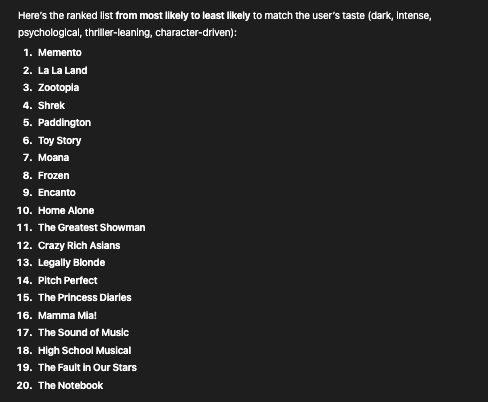

*Attach the failed cases here...*